# Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества F1 не меньше 0.75. 

***Описание данных***

Данные находятся в файле /datasets/toxic_comments.csv. 

Столбец text в нём содержит текст комментария, а toxic — целевой признак.


# Библиотеки

In [33]:
import pandas as pd
import numpy as np
import re
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import (classification_report, f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
#%pip install -q --no-binary lightgbm --config-settings=cmake.define.USE_OPENMP=OFF 'lightgbm>=4.0.0'
import lightgbm as lgb
from lightgbm import LGBMClassifier

%pip install -q nltk
import nltk
from nltk.corpus import stopwords
%pip install -q ssl
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download("stopwords") # поддерживает удаление стоп-слов
nltk.download('punkt') # делит текст на список предложений
nltk.download('wordnet') # проводит лемматизацию
from nltk.corpus import wordnet
%pip install -q wordcloud
from wordcloud import WordCloud

In [34]:
RANDOM_STATE=77

# Шаг 1. Загрузка данных, подготовка и EDA.

In [35]:
try:
    df = pd.read_csv("toxic_comments.csv")
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')

# delete 'Unnamed: 0' column
df = df.drop('Unnamed: 0', axis=1)

Видим дисбаланс:

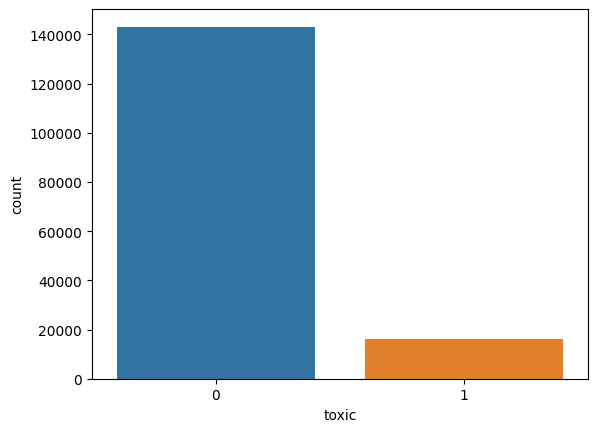

In [36]:
sns.countplot(data=df, x="toxic")

Посмотрим на облака слов среди токсичных и нетоксичных:

In [37]:
stop_words = set(stopwords.words('english'))

Токсичные комментарии:

In [38]:
toxic_comments = df[df['toxic'] == 1]
untoxic_comments = df[df['toxic'] == 0]

toxic_comments['text'] = toxic_comments['text']\
    .apply(lambda x: ' '.join([word for word in x.split()\
                                if word not in stop_words]))
untoxic_comments['text'] = untoxic_comments['text']\
    .apply(lambda x: ' '.join([word for word in x.split()\
                                if word not in stop_words]))

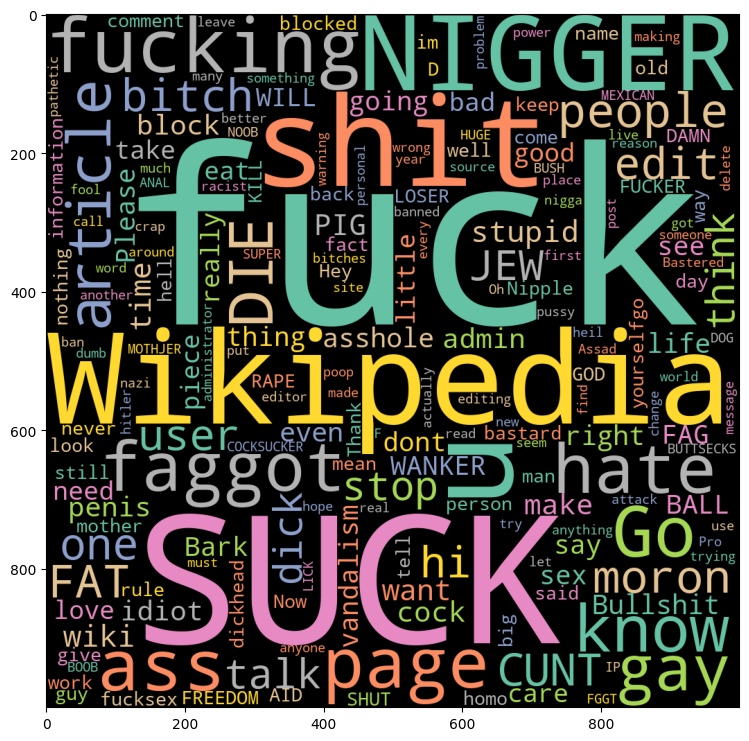

In [39]:
toxic_comments_word_cloud = WordCloud(width = 1000,
                      height = 1000,
                      random_state=1,
                      background_color='black',
                      colormap='Set2',
                      collocations=False).generate(" ".join(toxic_comments['text']))

plt.figure(figsize=(9,9))
plt.imshow(toxic_comments_word_cloud)

Нетоксичные комментарии:

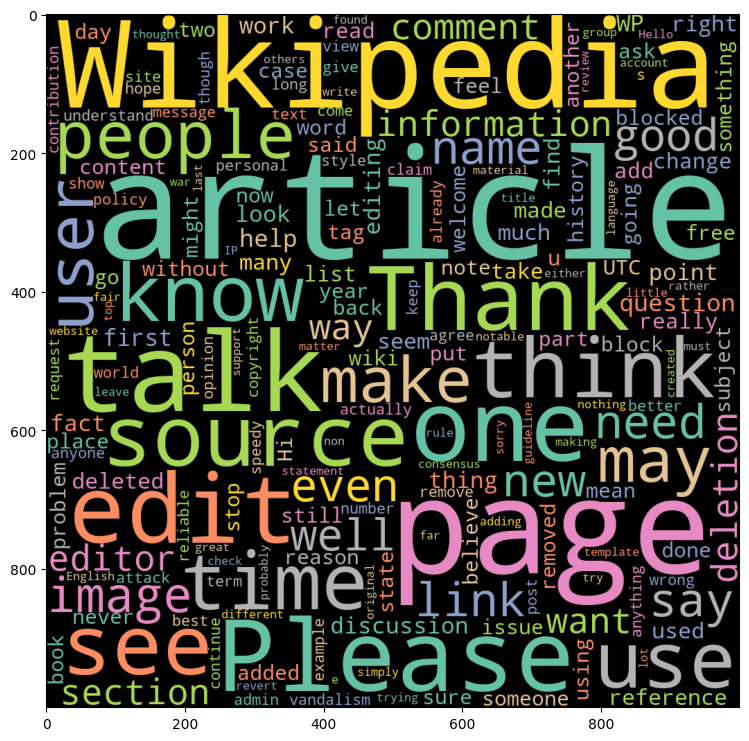

In [40]:
untoxic_comments_word_cloud = WordCloud(width = 1000,
                      height = 1000,
                      random_state=1,
                      background_color='black',
                      colormap='Set2',
                      collocations=False).generate(" ".join(untoxic_comments['text']))

plt.figure(figsize=(9,9))
plt.imshow(untoxic_comments_word_cloud)

In [41]:
del toxic_comments, untoxic_comments, toxic_comments_word_cloud, untoxic_comments_word_cloud

In [42]:
gc.collect()

Наглядно видим разницу в содержании токсичных с нетоксичными.

# Шаг 2. Обучение моделей модели.

Логистическая регрессия

In [43]:
df.loc[1, 'text']

Проведем предобработку (лемматизация, стеминг, приведение к нижнему регистру,...):

In [47]:
del df, stop_words, stopwords, wordnet

In [48]:
new_text = pd.read_csv('toxic_comments_lemmatized.csv')

In [49]:
new_text.isna().sum()

In [50]:
new_text = new_text.dropna()

Разбиваем на тренировочную и тестовую выборки:

In [51]:
X_train, X_test, y_train, y_test =\
    train_test_split(new_text['lemmatized_text'],
                     new_text['toxic'],test_size=0.2, stratify=new_text['toxic'],
                     random_state=1)

In [52]:
del new_text

In [53]:
pipeline = Pipeline(
    steps = [("tfidf", TfidfVectorizer() ),
             ("models",SVC(random_state=RANDOM_STATE, kernel='linear'))]
)

In [54]:
param_grid = [
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__learning_rate': [0.01, 0.1, 0.5]
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,3)
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='linear')],
        'models__C': [0.1, 1]
    }
]

In [55]:
randomized_search = RandomizedSearchCV(
    pipeline, 
    param_grid, 
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика (f1) лучшей модели на кросс-валидации:', round(randomized_search.best_score_,3))

bestmod = randomized_search.best_estimator_

Смотрим метрику на тесте:

In [58]:
predictions = bestmod.predict(X_test)
print(classification_report(y_test, predictions))

# Шаг 3. Выводы.

Проанализировали данные:
- обнаружили и удалили дисбаланс классов 
- визулизировали часто употребляемые слова в токсичных и нетоксичных комментариях с помощью облака слов

Предобработали данные:
- очистили текст от неалфавитных символов
- токенизировали
- лемматизировали
- удалили стоп-слова

Обучили разные модели и получили наилучшую:
```python
LogisticRegression(C=2, penalty='l1', random_state=77,
                                    solver='liblinear'))])
```
Метрика (f1) лучшей модели на кросс-валидации: 0.783
На тесте: 0.79